# FSL Preprocessing and GLM

This notebook showcases the FSL software package and performs preprocessing and first-level analysis on one subject from the Flanker dataset. The example is closely inspired by the FSL tutorial in Andy’s Brain Book and follows the steps outlined in *Chapter 4: Preprocessing* and *Chapter 5: Statistics and Modeling*. For detailed information about the dataset and analysis pipeline, refer to Andy’s original tutorial. 

####

__Author:__ Monika Doerig

__Citation:__

__Andy's Brain Book:__
- This FSL example is based on the [fMRI Short Course with FSL: Preprocessing](https://andysbrainbook.readthedocs.io/en/latest/fMRI_Short_Course/fMRI_Intro.html)  from Andy’s Brain Book (Jahn, 2022. [doi:10.5281/zenodo.5879293](https://zenodo.org/records/5879294))

__Data from OpenNeuro:__ Flanker Dataset

- Kelly AMC and Uddin LQ and Biswal BB and Castellanos FX and Milham MP (2018). Flanker task (event-related). [OpenNeuro Dataset ds000102](https://openneuro.org/datasets/ds000102/versions/00001/). [Dataset] doi: null
- Kelly AM, Uddin LQ, Biswal BB, Castellanos FX, Milham MP. Competition between functional brain networks mediates behavioral variability. Neuroimage. 2008 Jan 1;39(1):527-37. doi: [10.1016/j.neuroimage.2007.08.008](https://doi.org/10.1016/j.neuroimage.2007.08.008). Epub 2007 Aug 23. PMID: 17919929.
- Mennes, M., Kelly, C., Zuo, X.N., Di Martino, A., Biswal, B.B., Castellanos, F.X., Milham, M.P. (2010). Inter-individual differences in resting-state functional connectivity predict task-induced BOLD activity. Neuroimage, 50(4):1690-701. doi: [10.1016/j.neuroimage.2010.01.002](https://doi.org/10.1016/j.neuroimage.2010.01.002). Epub 2010 Jan 15. Erratum in: Neuroimage. 2011 Mar 1;55(1):434
- Mennes, M., Zuo, X.N., Kelly, C., Di Martino, A., Zang, Y.F., Biswal, B., Castellanos, F.X., Milham, M.P. (2011). Linking inter-individual differences in neural activation and behavior to intrinsic brain dynamics. Neuroimage, 54(4):2950-9. doi: [10.1016/j.neuroimage.2010.10.046](https://doi.org/10.1016/j.neuroimage.2010.10.046)

### Output CPU information

In [1]:
!cat /proc/cpuinfo | grep 'vendor' | uniq
!cat /proc/cpuinfo | grep 'model name' | uniq

vendor_id	: GenuineIntel
model name	: Intel(R) Xeon(R) Gold 6126 CPU @ 2.60GHz


## Load FSL and Import Python Libraries


In [2]:
%%capture
!pip install numpy nibabel nilearn

In [3]:
import module
await module.load('fsl/6.0.7.16')
await module.list()

['mrtrix3/3.0.4', 'fsl/6.0.7.16']

In [4]:
from ipyniivue import NiiVue
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import os
from nilearn.image import index_img
from IPython.display import Image, display, Markdown

In [5]:
# this makes it so FSL knows how we want our output files
os.environ["FSLOUTPUTTYPE"]="NIFTI_GZ"

## Data preparation

In [6]:
!datalad install https://github.com/OpenNeuroDatasets/ds000102.git
!cd ./ds000102 && datalad get sub-08

Cloning:   0%|                             | 0.00/2.00 [00:00<?, ? candidates/s]
Enumerating: 0.00 Objects [00:00, ? Objects/s]
                                              
Counting:   0%|                               | 0.00/27.0 [00:00<?, ? Objects/s]
                                                                                
Compressing:   0%|                            | 0.00/23.0 [00:00<?, ? Objects/s]
                                                                                
Receiving:   0%|                             | 0.00/2.15k [00:00<?, ? Objects/s]
                                                                                
Resolving:   0%|                                | 0.00/537 [00:00<?, ? Deltas/s]
[INFO   ] scanning for unlocked files (this may take some time)                 
[INFO   ] Remote origin not usable by git-annex; setting annex-ignore 
[INFO   ] access to 1 dataset sibling s3-PRIVATE not auto-enabled, enable with:
| 		datalad siblings -d "/

In [7]:
!tree -L 4 ./ds000102/sub-08/

./ds000102/sub-08/
├── anat
│   └── sub-08_T1w.nii.gz -> ../../.git/annex/objects/mw/MM/MD5E-s10561256--b94dddd8dc1c146aa8cd97f8d9994146.nii.gz/MD5E-s10561256--b94dddd8dc1c146aa8cd97f8d9994146.nii.gz
└── func
    ├── sub-08_task-flanker_run-1_bold.nii.gz -> ../../.git/annex/objects/zX/v9/MD5E-s28641609--47314e6d1a14b8545686110b5b67f8b8.nii.gz/MD5E-s28641609--47314e6d1a14b8545686110b5b67f8b8.nii.gz
    ├── sub-08_task-flanker_run-1_events.tsv
    ├── sub-08_task-flanker_run-2_bold.nii.gz -> ../../.git/annex/objects/WZ/F0/MD5E-s28636310--4535bf26281e1c5556ad0d3468e7fe4e.nii.gz/MD5E-s28636310--4535bf26281e1c5556ad0d3468e7fe4e.nii.gz
    └── sub-08_task-flanker_run-2_events.tsv

2 directories, 5 files


### Inspecting the anatomical and functional images

Before beginning any preprocessing or analysis, it's essential to visually inspect both anatomical and functional MRI data. This helps catch common issues such as motion artifacts, abnormal intensities, or poor image quality that could affect downstream results. To look at the data with FSL’s image viewer, you would type:
```javascript
fsleyes ds000102/sub-08/anat/sub-08_T1w.nii.gz
```
We will use **NiiVue** to look at the data:

In [8]:
#extract first volume of functional images
index_img("./ds000102/sub-08/func/sub-08_task-flanker_run-1_bold.nii.gz", 0).to_filename("./FSL_preproc/sub-08_task-flanker_run-1_bold_vol0.nii.gz")
index_img("./ds000102/sub-08/func/sub-08_task-flanker_run-2_bold.nii.gz", 0).to_filename("./FSL_preproc/sub-08_task-flanker_run-2_bold_vol0.nii.gz")

In [9]:
# anatomical image
nv = NiiVue()
nv.load_volumes([{"path": "./ds000102/sub-08/anat/sub-08_T1w.nii.gz"}])
nv

NiiVue(height=300)

In [10]:
Image(url='https://raw.githubusercontent.com/NeuroDesk/example-notebooks/refs/heads/main/books/images/fsl_preproc_anat.png')

In [11]:
# functional image run 1, first volume
nv = NiiVue()
nv.load_volumes([{"path": "./FSL_preproc/sub-08_task-flanker_run-1_bold_vol0.nii.gz"}])
nv

NiiVue(height=300)

In [12]:
Image(url='https://raw.githubusercontent.com/NeuroDesk/example-notebooks/refs/heads/main/books/images/fsl_preproc_run1.png')

In [13]:
# functional image run 2
nv = NiiVue()
nv.load_volumes([{"path": "./FSL_preproc/sub-08_task-flanker_run-2_bold_vol0.nii.gz"}])
nv

NiiVue(height=300)

In [14]:
Image(url='https://raw.githubusercontent.com/NeuroDesk/example-notebooks/refs/heads/main/books/images/fsl_preproc_run2.png')

## 1. Preprocessing

### Brain Extraction
The first step is to remove the skull and non-brain areas from the image with FSL's `bet`, the Brain Extraction Tool.


In [14]:
! bet -help


Usage:    bet <input> <output> [options]

Main bet2 options:
  -o          generate brain surface outline overlaid onto original image
  -m          generate binary brain mask
  -s          generate approximate skull image
  -n          don't generate segmented brain image output
  -f <f>      fractional intensity threshold (0->1); default=0.5; smaller values give larger brain outline estimates
  -g <g>      vertical gradient in fractional intensity threshold (-1->1); default=0; positive values give larger brain outline at bottom, smaller at top
  -r <r>      head radius (mm not voxels); initial surface sphere is set to half of this
  -c <x y z>  centre-of-gravity (voxels not mm) of initial mesh surface.
  -t          apply thresholding to segmented brain image and mask
  -e          generates brain surface as mesh in .vtk format

Variations on default bet2 functionality (mutually exclusive options):
  (default)   just run bet2
  -R          robust brain centre estimation (iterates BE

In [15]:
# Brain extraction with default settings, set input and output image 
!mkdir -p FSL_preproc
!bet ./ds000102/sub-08/anat/sub-08_T1w.nii.gz ./FSL_preproc/sub-08_T1w_brain.nii.gz

#### Visualization of the brain extracted image
Check the following overlay image for areas where too much brain tissue has been removed or where parts of the skull haven’t been fully stripped away. The goal is to produce an image where the skull and face are completely removed, leaving only the brain—cortex, subcortical structures, brainstem, and cerebellum—intact.

In [16]:
# Visualize the skull-stripped (red) on top of the original T1 anatomical image
nv = NiiVue()
nv.load_volumes([
    {"path": "./ds000102/sub-08/anat/sub-08_T1w.nii.gz", "name": "T1w", "colormap": "gray"},
    {"path": "./FSL_preproc/sub-08_T1w_brain.nii.gz", "name": "T1w_brain", "colormap": "red", "opacity": 0.5}
]) 
nv

NiiVue(height=300)

In [50]:
Image(url='https://raw.githubusercontent.com/NeuroDesk/example-notebooks/refs/heads/main/books/images/fsl_preproc_bet_05.png')

### Fixing a bad skullstrip
If the skullstripping results aren't satisfactory, you can adjust the parameters in the `bet` command. The `-f` option sets the fractional intensity threshold, which controls how much brain tissue is included—lower values result in a more generous brain mask, while higher values are more conservative. If too much brain was removed, try lowering the threshold. For example:

In [18]:
!bet ./ds000102/sub-08/anat/sub-08_T1w.nii.gz ./FSL_preproc/sub-08_T1w_brain_f02.nii.gz -f 0.2

In [19]:
# Overlay brain extacted image with f=0.2 in red color ontop of the previous one with f=0.5 (gray)
nv = NiiVue()
nv.load_volumes([
    {"path": "./FSL_preproc/sub-08_T1w_brain_f02.nii.gz", "colormap": "gray", "opacity": 1.0},
    {"path": "./FSL_preproc/sub-08_T1w_brain.nii.gz", "colormap": "red", "opacity": 0.5},
]) 
nv

NiiVue(height=300)

In [51]:
Image(url='https://raw.githubusercontent.com/NeuroDesk/example-notebooks/refs/heads/main/books/images/fsl_preproc_bet_02.png')

### Motion Correction
Motion correction realigns all volumes in a time series to a single reference volume to correct for head movement during the scan. The reference volume is typically the first, middle, or last volume in the series. FSL’s `mcflirt` can perform this correction by aligning each volume to the selected reference using rigid-body transformations that undo any detected motion.

The following commands use the first volume as the reference (- refvol 0) to perform motion correction:

In [21]:
#apply motion correction to the functional image with FSL MCFLIRT
!mcflirt -in ./ds000102/sub-08/func/sub-08_task-flanker_run-1_bold.nii.gz -out ./FSL_preproc/sub-08_task-flanker_run-1_bold_mcf.nii.gz -plots -refvol 0
!mcflirt -in ./ds000102/sub-08/func/sub-08_task-flanker_run-2_bold.nii.gz -out ./FSL_preproc/sub-08_task-flanker_run-2_bold_mcf.nii.gz -plots -refvol 0

### Slice-Timing Correction
FSL does not perform slice-timing correction by default. Instead, it accounts for timing differences by including a temporal derivative in the statistical model.


### Smoothing
Smoothing replaces each voxel’s signal with a weighted average of its neighbors, reducing noise at the cost of spatial resolution. While this blurs the image, it can enhance the signal-to-noise ratio by minimizing random fluctuations. Smoothing also helps improve statistical power and facilitates normalization to a standard template, as it makes anatomical differences between subjects less pronounced.
To apply smoothing using `fslmaths`, the smoothing kernel is defined by its sigma (standard deviation). However, smoothing parameters are often specified using Full Width at Half Maximum (FWHM). To convert FWHM to sigma, use the formula:

$\text{𝜎} = FWHM/ \sqrt{8 \ln 2} = FWHM/  \approx 2.3548 \ $ 
 

For a FWHM of 5 mm, this gives:

$\text{𝜎} = 5/2.3548 ≈ 2.1 \ $

In [22]:
#Spatial smoothing FWHM=5mm (𝜎=2.1)
!fslmaths ./FSL_preproc/sub-08_task-flanker_run-1_bold_mcf.nii.gz -s 2.1 ./FSL_preproc/sub-08_task-flanker_run-1_bold_mcf_smooth.nii.gz
!fslmaths ./FSL_preproc/sub-08_task-flanker_run-2_bold_mcf.nii.gz -s 2.1 ./FSL_preproc/sub-08_task-flanker_run-2_bold_mcf_smooth.nii.gz

### Registration and Normalization
Registration aligns functional images to the subject’s anatomical scan, while normalization aligns the anatomical scan to a standard template (e.g., MNI). Both steps involve estimating transformations and applying them to the data. The typical steps include:

1. Initial Alignment: The functional and anatomical images are assumed to be roughly in the same location. If not, the outlines of the images are aligned.

2. Mutual Information: Given that the anatomical and functional images have different contrast weightings (e.g., cerebrospinal fluid appears dark in the anatomical image but bright in the functional image), the algorithm uses this contrast difference. It matches bright voxels on one image to dark voxels on the other by testing different overlays until the best alignment is found.

3. Transformation: Once the optimal match is achieved, the transformations used to align the anatomical image to the template are also applied to the functional images.

__1. Extract a representative volume from each functional run (for flirt)__

In [23]:
# Calculate the middle volume indices (timepoints) for each file
middle_index1 = nib.load("./FSL_preproc/sub-08_task-flanker_run-1_bold_mcf_smooth.nii.gz").shape[3] // 2
middle_index2 = nib.load("./FSL_preproc/sub-08_task-flanker_run-2_bold_mcf_smooth.nii.gz").shape[3] // 2

print(middle_index1)

73


In [24]:
!fslroi ./FSL_preproc/sub-08_task-flanker_run-1_bold_mcf_smooth.nii.gz ./FSL_preproc/sub-08_task-flanker_run-1_bold_mcf_smooth_middle.nii.gz {middle_index1} 1
!fslroi ./FSL_preproc/sub-08_task-flanker_run-2_bold_mcf_smooth.nii.gz ./FSL_preproc/sub-08_task-flanker_run-2_bold_mcf_smooth_middle.nii.gz {middle_index2} 1

__2. Register functional to anatomical (EPI to T1w)__

Use full 3D search and 12 DOF for better alignment

- Search options (`-searchrx/y/z`): Correspond to Full search in the FSL GUI, covering the full 3D rotation space (-180 to 180 degrees) to improve alignment.

- Degrees of Freedom (`-dof 12`): Allows affine transformations including translation, rotation, scaling, and shearing.

In [25]:
!flirt -in ./FSL_preproc/sub-08_task-flanker_run-1_bold_mcf_smooth_middle.nii.gz -ref ./FSL_preproc/sub-08_T1w_brain_f02.nii.gz -out ./FSL_preproc/sub-08_task-flanker_run-1_bold_mcf_smooth_flirt.nii.gz -omat ./FSL_preproc/sub-08_task-flanker_run-1_bold_mcf_smooth_flirt.mat -searchrx -180 180 -searchry -180 180 -searchrz -180 180 -dof 12
!flirt -in ./FSL_preproc/sub-08_task-flanker_run-2_bold_mcf_smooth_middle.nii.gz -ref ./FSL_preproc/sub-08_T1w_brain_f02.nii.gz -out ./FSL_preproc/sub-08_task-flanker_run-2_bold_mcf_smooth_flirt.nii.gz -omat ./FSL_preproc/sub-08_task-flanker_run-2_bold_mcf_smooth_flirt.mat -searchrx -180 180 -searchry -180 180 -searchrz -180 180 -dof 12

__3. Register anatomical to MNI template (T1w to MNI)__

Same settings: full search, 12 DOF

In [26]:
# extract the mni template
fsl_path = !which fsl
fsl_version = fsl_path[0].split('_')[1]

MNI_BRAIN = os.path.join(
    '/opt',
    f'fsl-{fsl_version}',
    'data',
    'standard',
    'MNI152_T1_2mm_brain.nii.gz'
)

print(MNI_BRAIN)

/opt/fsl-6.0.7.16/data/standard/MNI152_T1_2mm_brain.nii.gz


In [27]:
# Register the T1w image to the MNI template and concatenate the transformation matrices
!flirt -in ./FSL_preproc/sub-08_T1w_brain_f02.nii.gz -ref "{MNI_BRAIN}" -out ./FSL_preproc/sub-08_T1w_brain_f02_flirt.nii.gz -omat ./FSL_preproc/sub-08_T1w_brain_f02_flirt.mat -searchrx -180 180 -searchry -180 180 -searchrz -180 180 -dof 12

__4. Concatenate transforms__

Combines functional → T1w and T1w → MNI into a single matrix

⚠️ There's an important ordering rule when using `convert_xfm -concat` that you must follow:


**result = mat2 * mat1**


So, `convert_xfm -omat output.mat -concat A.mat B.mat` applys B first, then A.

In [28]:
!convert_xfm -omat ./FSL_preproc/sub-08_task-flanker_run-1_bold_mcf_smooth_flirt2mni.mat -concat ./FSL_preproc/sub-08_T1w_brain_f02_flirt.mat ./FSL_preproc/sub-08_task-flanker_run-1_bold_mcf_smooth_flirt.mat
!convert_xfm -omat ./FSL_preproc/sub-08_task-flanker_run-2_bold_mcf_smooth_flirt2mni.mat -concat ./FSL_preproc/sub-08_T1w_brain_f02_flirt.mat ./FSL_preproc/sub-08_task-flanker_run-2_bold_mcf_smooth_flirt.mat

__5. Apply the transform to the full 4D functional data__

Applies the final 

`Functional → Anatomical → MNI`

transform in a single step using the .mat file created earlier, and resampling the functional images into MNI space.

In [29]:
# Apply the concatenated transformation matrices to the functional images
!flirt -in ./FSL_preproc/sub-08_task-flanker_run-1_bold_mcf_smooth.nii.gz -ref "{MNI_BRAIN}" -out ./FSL_preproc/sub-08_task-flanker_run-1_bold_mcf_smooth_flirt2mni.nii.gz -applyxfm -init ./FSL_preproc/sub-08_task-flanker_run-1_bold_mcf_smooth_flirt2mni.mat
!flirt -in ./FSL_preproc/sub-08_task-flanker_run-2_bold_mcf_smooth.nii.gz -ref "{MNI_BRAIN}" -out ./FSL_preproc/sub-08_task-flanker_run-2_bold_mcf_smooth_flirt2mni.nii.gz -applyxfm -init ./FSL_preproc/sub-08_task-flanker_run-2_bold_mcf_smooth_flirt2mni.mat

### Checking Preprocessing
__Alignment__

To visualize the alignment of functional run 1 in MNI space, the middle volume of the 4D dataset will be extracted and used as an overlay. Extracting a single volume instead of displaying the full 4D image reduces file size and computational load, making it more efficient for visualization and suitable for interactive display tools such as NiiVue.

In [30]:
index_img("./FSL_preproc/sub-08_task-flanker_run-2_bold_mcf_smooth_flirt2mni.nii.gz", middle_index1).to_filename("./FSL_preproc/sub-08_task-flanker_run-2_bold_mcf_smooth_flirt2mni_middle_3d.nii.gz")

In [31]:
# Verify the registration by overlaying the functional image on MNI
nv = NiiVue()  
nv.load_volumes([
    {"path": "/cvmfs/neurodesk.ardc.edu.au/containers/fsl_6.0.7.16_20250131/fsl_6.0.7.16_20250131.simg/opt/fsl-6.0.7.16/data/standard/MNI152_T1_2mm_brain.nii.gz",  "colormap": "gray"},
    {"path": "./FSL_preproc/sub-08_task-flanker_run-2_bold_mcf_smooth_flirt2mni_middle_3d.nii.gz", "colormap": "red", "opacity": 0.7}
])
nv

NiiVue(height=300)

In [52]:
Image(url='https://raw.githubusercontent.com/NeuroDesk/example-notebooks/refs/heads/main/books/images/fsl_preproc_alignment.png')

__Motion parameters__

The motion plots show translation and rotation over time, with each timepoint (volume) on the x-axis. For translation, values are in millimeters. Look for sudden spikes greater than half the voxel size, or gradual drifts exceeding a full voxel. For example, with 3 mm isotropic voxels, relative motion over 1.5 mm between volumes or absolute shifts over 3 mm across the run may warrant closer inspection.

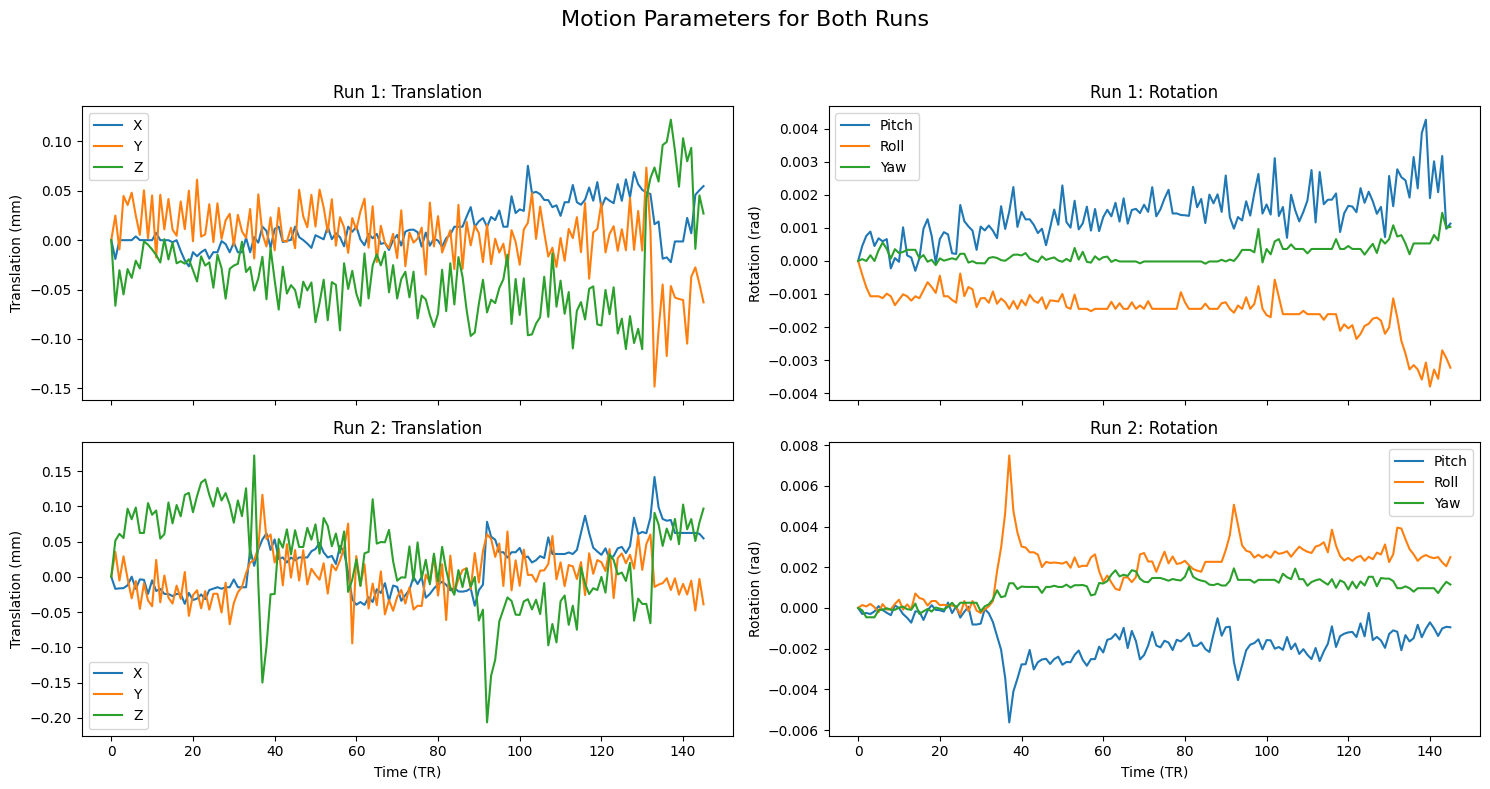

In [33]:
# Load motion parameters
motion_params_run1 = np.loadtxt('./FSL_preproc/sub-08_task-flanker_run-1_bold_mcf.nii.gz.par')
motion_params_run2 = np.loadtxt('./FSL_preproc/sub-08_task-flanker_run-2_bold_mcf.nii.gz.par')

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 8), sharex=True)

# Run 1
axes[0, 0].plot(motion_params_run1[:, 3:])
axes[0, 0].set_ylabel("Translation (mm)")
axes[0, 0].legend(["X", "Y", "Z"])
axes[0, 0].set_title("Run 1: Translation")

axes[0, 1].plot(motion_params_run1[:, :3])
axes[0, 1].set_ylabel("Rotation (rad)")
axes[0, 1].legend(["Pitch", "Roll", "Yaw"])
axes[0, 1].set_title("Run 1: Rotation")

# Run 2
axes[1, 0].plot(motion_params_run2[:, 3:])
axes[1, 0].set_ylabel("Translation (mm)")
axes[1, 0].set_xlabel("Time (TR)")
axes[1, 0].legend(["X", "Y", "Z"])
axes[1, 0].set_title("Run 2: Translation")

axes[1, 1].plot(motion_params_run2[:, :3])
axes[1, 1].set_ylabel("Rotation (rad)")
axes[1, 1].set_xlabel("Time (TR)")
axes[1, 1].legend(["Pitch", "Roll", "Yaw"])
axes[1, 1].set_title("Run 2: Rotation")

# Adjust layout
fig.suptitle("Motion Parameters for Both Runs", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## 2. Statistics and Modeling

### Create timing files
To prepare condition-specific regressors for FSL analysis, timing files are required that specify the onset and duration of each event type. These are extracted from each subject’s events.tsv files. One timing file is generated per condition per run, formatted for use in FSL.

A Bash script called `make_FSL_Timings.sh` can be used to automate this step. It is available from Andy’s [FSL_Scripts repository](https://github.com/andrewjahn/FSL_Scripts/blob/master/make_FSL_Timings.sh) and should be placed in the directory containing the subject folders (e.g., ds000102/). Running the script will produce timing files in the appropriate format.

*NOTE*: This script only extracts the trials in which the subject made a correct response. Accuracy is nearly 100% for all subjects, but as an exercise you can modify this to extract the incorrect trials as well.

In [34]:
# Download timing file from Andy's FSL_Scripts repository
!wget -O ./ds000102/make_FSL_Timings.sh https://raw.githubusercontent.com/andrewjahn/FSL_Scripts/master/make_FSL_Timings.sh

--2025-06-10 23:55:04--  https://raw.githubusercontent.com/andrewjahn/FSL_Scripts/master/make_FSL_Timings.sh
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1220 (1.2K) [text/plain]
Saving to: ‘./ds000102/make_FSL_Timings.sh’

./ds000102/make_FSL 100%[===================>]   1.19K  --.-KB/s    in 0s      

2025-06-10 23:55:04 (106 MB/s) - ‘./ds000102/make_FSL_Timings.sh’ saved [1220/1220]



In [35]:
# Show the file
!cat ./ds000102/make_FSL_Timings.sh

#!/bin/bash

#Check whether the file subjList.txt exists; if not, create it
if [ ! -f subjList.txt ]; then
        ls -d sub-?? > subjList.txt
fi

#Loop over all subjects and format timing files into FSL format
for subj in `cat subjList.txt` ; do
        cd $subj/func #Navigate to the subject's func directory, which contains the timing files
        
        #Extract the onset times for the incongruent and congruent trials for each run. NOTE: This script only extracts the trials in which the subject made a correct response. Accuracy is nearly 100% for all subjects, but as an exercise the student can modify this to extract the incorrect trials as well.
        cat ${subj}_task-flanker_run-1_events.tsv | awk '{if ($3=="incongruent_correct") {print $1, $2, "1"}}' > incongruent_run1.txt
        cat ${subj}_task-flanker_run-1_events.tsv | awk '{if ($3=="congruent_correct") {print $1, $2, "1"}}' > congruent_run1.txt

        cat ${subj}_task-flanker_run-2_events.tsv | awk '{if ($3=="incongru

In [36]:
# Run the file to get individual timing files for each run
!cd ./ds000102 && chmod +x make_FSL_Timings.sh && bash make_FSL_Timings.sh

Inspect the output:

In [37]:
!cat ./ds000102/sub-08/func/incongruent_run1.txt

0.0 2.0 1
10.0 2.0 1
20.0 2.0 1
52.0 2.0 1
88.0 2.0 1
130.0 2.0 1
144.0 2.0 1
174.0 2.0 1
248.0 2.0 1
260.0 2.0 1
274.0 2.0 1


### Running the First-Level Analysis
As introduced in the beginning, this example uses the Flanker dataset, which is also described in [Andy's Brain Book](https://andysbrainbook.readthedocs.io/en/latest/fMRI_Short_Course/fMRI_02_ExperimentalDesign.html).
The contrasts are set up to compare congruent and incongruent trial types, reflecting typical cognitive control analyses.

#### FEAT Design Files for both runs
This file configures a first-level GLM analysis in FSL, skipping preprocessing steps and assuming the input data has already been preprocessed. Each `.fsf file` is tailored to a specific run, with unique input files and event timing. Below are the key sections to review and understand.

✅ **General Analysis Settings**
- set fmri(level) 1: This is a first-level analysis (within-subject, per-run).

- set fmri(analysis) 2: Only the Statistics stage is run (preprocessing is skipped).

- set feat_files(1): Points to the preprocessed functional NIfTI file to analyze.

- set fmri(outputdir): Path to where the FEAT results will be saved.


🧠 **Model Specification**
Two Explanatory Variables (EVs):

- evtitle1: "incongruent"

- evtitle2: "congruent"

Each EV uses:

- Custom timing files (custom1, custom2) in 3-column format (onset, duration, amplitude).

- Double-Gamma HRF (set fmri(convolve1) 2).

- No temporal derivative added (keeps design simpler to inspect).

📊 **Contrasts**
Three contrasts are defined:

- "incongruent": [1 0]

- "congruent": [0 1]

- "incongruent-congruent": [1 -1]

These correspond to cope1, cope2, and cope3, respectively.

This setup allows testing condition effects vs baseline, and the difference between conditions.

⚙️ **Other Notable Settings**
- TR: 2s (extracted from images)

- Volumes: 146 (extracted from images)

- Highpass filter: 100s cutoff

- No motion regressors: (assumed already regressed out or not needed)

- No registration: Standard space registration is enabled, but main structural registration is off (reghighres_yn is 0).

- No pre-stats or post-stats steps (filtering_yn = 0, poststats_yn = 0).

In [38]:
# Get parameters for the design files
cwd = os.getcwd()
img1 = nib.load('./FSL_preproc/sub-08_task-flanker_run-1_bold_mcf_smooth_flirt2mni.nii.gz')
img2 = nib.load('./FSL_preproc/sub-08_task-flanker_run-2_bold_mcf_smooth_flirt2mni.nii.gz')
x1, y1, z1, t1 = img1.shape
x2, y2, z2, t2 = img2.shape
TR1 = img1.header.get_zooms()[3]
TR2 = img2.header.get_zooms()[3]

# Define run-specific parameters
runs = {
    "run1": {
        "outputdir": os.path.join(cwd, 'feat_run_1'),
        "TR": TR1,
        "npts": t1,
        "total_voxels": x1 * y1 * z1 * t1,
        "func": os.path.join(cwd, 'FSL_preproc/sub-08_task-flanker_run-1_bold_mcf_smooth_flirt2mni'),
        "incongruent": os.path.join(cwd, 'ds000102/sub-08/func/incongruent_run1.txt'),
        "congruent": os.path.join(cwd, 'ds000102/sub-08/func/congruent_run1.txt'),
        "design_file": "design_run1.fsf"
    },
    "run2": {
        "outputdir": os.path.join(cwd, 'feat_run_2'),
        "TR": TR2,
        "npts": t2,
        "total_voxels": x2 * y2 * z2 * t2,
        "func": os.path.join(cwd, 'FSL_preproc/sub-08_task-flanker_run-2_bold_mcf_smooth_flirt2mni'),
        "incongruent": os.path.join(cwd, 'ds000102/sub-08/func/incongruent_run2.txt'),
        "congruent": os.path.join(cwd, 'ds000102/sub-08/func/congruent_run2.txt'),
        "design_file": "design_run2.fsf"
    }
}

In [39]:
# Create feat design files for both runs
for run_key, params in runs.items():
    with open(params["design_file"], "w") as f:
        f.write(f"""
# FEAT version number
set fmri(version) 6.00

# Are we in MELODIC?
set fmri(inmelodic) 0

# Analysis level
# 1 : First-level analysis
# 2 : Higher-level analysis
set fmri(level) 1

# Which stages to run
# 0 : No first-level analysis (registration and/or group stats only)
# 7 : Full first-level analysis
# 1 : Pre-processing
# 2 : Statistics
set fmri(analysis) 2

# Use relative filenames
set fmri(relative_yn) 0

# Balloon help
set fmri(help_yn) 1

# Run Featwatcher
set fmri(featwatcher_yn) 1

# Cleanup first-level standard-space images
set fmri(sscleanup_yn) 0

# Output directory
set fmri(outputdir)  "{params['outputdir']}"

# TR(s)
set fmri(tr) {params['TR']}

# Total volumes
set fmri(npts) {params['npts']}

# Delete volumes
set fmri(ndelete) 0

# Perfusion tag/control order
set fmri(tagfirst) 1

# Number of first-level analyses
set fmri(multiple) 1

# Higher-level input type
# 1 : Inputs are lower-level FEAT directories
# 2 : Inputs are cope images from FEAT directories
set fmri(inputtype) 2

# Carry out pre-stats processing?
set fmri(filtering_yn) 0

# Brain/background threshold, %
set fmri(brain_thresh) 10

# Critical z for design efficiency calculation
set fmri(critical_z) 5.3

# Noise level
set fmri(noise) 0.66

# Noise AR(1)
set fmri(noisear) 0.34

# Motion correction
# 0 : None
# 1 : MCFLIRT
set fmri(mc) 1

# Spin-history (currently obsolete)
set fmri(sh_yn) 0

# B0 fieldmap unwarping?
set fmri(regunwarp_yn) 0

# GDC Test
set fmri(gdc) ""

# EPI dwell time (ms)
set fmri(dwell) 0.0

# EPI TE (ms)
set fmri(te) 0.0

# % Signal loss threshold
set fmri(signallossthresh) 10

# Unwarp direction
set fmri(unwarp_dir) y-

# Slice timing correction
# 0 : None
# 1 : Regular up (0, 1, 2, 3, ...)
# 2 : Regular down
# 3 : Use slice order file
# 4 : Use slice timings file
# 5 : Interleaved (0, 2, 4 ... 1, 3, 5 ... )
set fmri(st) 0

# Slice timings file
set fmri(st_file) ""

# BET brain extraction
set fmri(bet_yn) 1

# Spatial smoothing FWHM (mm)
set fmri(smooth) 5

# Intensity normalization
set fmri(norm_yn) 0

# Perfusion subtraction
set fmri(perfsub_yn) 0

# Highpass temporal filtering
set fmri(temphp_yn) 1

# Lowpass temporal filtering
set fmri(templp_yn) 0

# MELODIC ICA data exploration
set fmri(melodic_yn) 0

# Carry out main stats?
set fmri(stats_yn) 1

# Carry out prewhitening?
set fmri(prewhiten_yn) 1

# Add motion parameters to model
# 0 : No
# 1 : Yes
set fmri(motionevs) 0
set fmri(motionevsbeta) ""
set fmri(scriptevsbeta) ""

# Robust outlier detection in FLAME?
set fmri(robust_yn) 0

# Higher-level modelling
# 3 : Fixed effects
# 0 : Mixed Effects: Simple OLS
# 2 : Mixed Effects: FLAME 1
# 1 : Mixed Effects: FLAME 1+2
set fmri(mixed_yn) 2

# Higher-level permutations
set fmri(randomisePermutations) 5000

# Number of EVs
set fmri(evs_orig) 2
set fmri(evs_real) 2
set fmri(evs_vox) 0

# Number of contrasts
set fmri(ncon_orig) 3
set fmri(ncon_real) 3

# Number of F-tests
set fmri(nftests_orig) 0
set fmri(nftests_real) 0

# Add constant column to design matrix? (obsolete)
set fmri(constcol) 0

# Carry out post-stats steps?
set fmri(poststats_yn) 0

# Pre-threshold masking?
set fmri(threshmask) ""

# Thresholding
# 0 : None
# 1 : Uncorrected
# 2 : Voxel
# 3 : Cluster
set fmri(thresh) 3

# P threshold
set fmri(prob_thresh) 0.05

# Z threshold
set fmri(z_thresh) 3.1

# Z min/max for colour rendering
# 0 : Use actual Z min/max
# 1 : Use preset Z min/max
set fmri(zdisplay) 0

# Z min in colour rendering
set fmri(zmin) 2

# Z max in colour rendering
set fmri(zmax) 8

# Colour rendering type
# 0 : Solid blobs
# 1 : Transparent blobs
set fmri(rendertype) 1

# Background image for higher-level stats overlays
# 1 : Mean highres
# 2 : First highres
# 3 : Mean functional
# 4 : First functional
# 5 : Standard space template
set fmri(bgimage) 1

# Create time series plots
set fmri(tsplot_yn) 1

# Registration to initial structural
set fmri(reginitial_highres_yn) 0

# Search space for registration to initial structural
# 0   : No search
# 90  : Normal search
# 180 : Full search
set fmri(reginitial_highres_search) 90

# Degrees of Freedom for registration to initial structural
set fmri(reginitial_highres_dof) 3

# Registration to main structural
set fmri(reghighres_yn) 0

# Search space for registration to main structural
# 0   : No search
# 90  : Normal search
# 180 : Full search
set fmri(reghighres_search) 90

# Degrees of Freedom for registration to main structural
set fmri(reghighres_dof) BBR

# Registration to standard image?
set fmri(regstandard_yn) 1

# Use alternate reference images?
set fmri(alternateReference_yn) 0

# Standard image
set fmri(regstandard) "{MNI_BRAIN}"

# Search space for registration to standard space
# 0   : No search
# 90  : Normal search
# 180 : Full search
set fmri(regstandard_search) 90

# Degrees of Freedom for registration to standard space
set fmri(regstandard_dof) 12

# Do nonlinear registration from structural to standard space?
set fmri(regstandard_nonlinear_yn) 0

# Control nonlinear warp field resolution
set fmri(regstandard_nonlinear_warpres) 10

# High pass filter cutoff
set fmri(paradigm_hp) 100

# Total voxels
set fmri(totalVoxels) {params['total_voxels']}


# Number of lower-level copes feeding into higher-level analysis
set fmri(ncopeinputs) 0

# 4D AVW data or FEAT directory (1)
set feat_files(1) "{params['func']}"

# Add confound EVs text file
set fmri(confoundevs) 0

# EV 1 title
set fmri(evtitle1) "incongruent"

# Basic waveform shape (EV 1)
# 0 : Square
# 1 : Sinusoid
# 2 : Custom (1 entry per volume)
# 3 : Custom (3 column format)
# 4 : Interaction
# 10 : Empty (all zeros)
set fmri(shape1) 3

# Convolution (EV 1)
# 0 : None
# 1 : Gaussian
# 2 : Gamma
# 3 : Double-Gamma HRF
# 4 : Gamma basis functions
# 5 : Sine basis functions
# 6 : FIR basis functions
# 8 : Alternate Double-Gamma
set fmri(convolve1) 2

# Convolve phase (EV 1)
set fmri(convolve_phase1) 0

# Apply temporal filtering (EV 1)
set fmri(tempfilt_yn1) 1

# Add temporal derivative (EV 1)
set fmri(deriv_yn1) 0

# Custom EV file (EV 1)
set fmri(custom1) "{params['incongruent']}"

# Gamma sigma (EV 1)
set fmri(gammasigma1) 3

# Gamma delay (EV 1)
set fmri(gammadelay1) 6

# Orthogonalise EV 1 wrt EV 0
set fmri(ortho1.0) 0

# Orthogonalise EV 1 wrt EV 1
set fmri(ortho1.1) 0

# Orthogonalise EV 1 wrt EV 2
set fmri(ortho1.2) 0

# EV 2 title
set fmri(evtitle2) "congruent"

# Basic waveform shape (EV 2)
# 0 : Square
# 1 : Sinusoid
# 2 : Custom (1 entry per volume)
# 3 : Custom (3 column format)
# 4 : Interaction
# 10 : Empty (all zeros)
set fmri(shape2) 3

# Convolution (EV 2)
# 0 : None
# 1 : Gaussian
# 2 : Gamma
# 3 : Double-Gamma HRF
# 4 : Gamma basis functions
# 5 : Sine basis functions
# 6 : FIR basis functions
# 8 : Alternate Double-Gamma
set fmri(convolve2) 2

# Convolve phase (EV 2)
set fmri(convolve_phase2) 0

# Apply temporal filtering (EV 2)
set fmri(tempfilt_yn2) 1

# Add temporal derivative (EV 2)
set fmri(deriv_yn2) 0

# Custom EV file (EV 2)
set fmri(custom2) "{params['congruent']}"

# Gamma sigma (EV 2)
set fmri(gammasigma2) 3

# Gamma delay (EV 2)
set fmri(gammadelay2) 6

# Orthogonalise EV 2 wrt EV 0
set fmri(ortho2.0) 0

# Orthogonalise EV 2 wrt EV 1
set fmri(ortho2.1) 0

# Orthogonalise EV 2 wrt EV 2
set fmri(ortho2.2) 0

# Contrast & F-tests mode
# real : control real EVs
# orig : control original EVs
set fmri(con_mode_old) orig
set fmri(con_mode) orig

# Display images for contrast_real 1
set fmri(conpic_real.1) 1

# Title for contrast_real 1
set fmri(conname_real.1) "incongruent"

# Real contrast_real vector 1 element 1
set fmri(con_real1.1) 1

# Real contrast_real vector 1 element 2
set fmri(con_real1.2) 0

# Display images for contrast_real 2
set fmri(conpic_real.2) 1

# Title for contrast_real 2
set fmri(conname_real.2) "congruent"

# Real contrast_real vector 2 element 1
set fmri(con_real2.1) 0

# Real contrast_real vector 2 element 2
set fmri(con_real2.2) 1.0

# Display images for contrast_real 3
set fmri(conpic_real.3) 1

# Title for contrast_real 3
set fmri(conname_real.3) "incongruent-congruent"

# Real contrast_real vector 3 element 1
set fmri(con_real3.1) 1.0

# Real contrast_real vector 3 element 2
set fmri(con_real3.2) -1.0

# Display images for contrast_orig 1
set fmri(conpic_orig.1) 1

# Title for contrast_orig 1
set fmri(conname_orig.1) "incongruent"

# Real contrast_orig vector 1 element 1
set fmri(con_orig1.1) 1

# Real contrast_orig vector 1 element 2
set fmri(con_orig1.2) 0

# Display images for contrast_orig 2
set fmri(conpic_orig.2) 1

# Title for contrast_orig 2
set fmri(conname_orig.2) "congruent"

# Real contrast_orig vector 2 element 1
set fmri(con_orig2.1) 0

# Real contrast_orig vector 2 element 2
set fmri(con_orig2.2) 1.0

# Display images for contrast_orig 3
set fmri(conpic_orig.3) 1

# Title for contrast_orig 3
set fmri(conname_orig.3) "incongruent-congruent"

# Real contrast_orig vector 3 element 1
set fmri(con_orig3.1) 1.0

# Real contrast_orig vector 3 element 2
set fmri(con_orig3.2) -1.0

# Contrast masking - use >0 instead of thresholding?
set fmri(conmask_zerothresh_yn) 0

# Mask real contrast/F-test 1 with real contrast/F-test 2?
set fmri(conmask1_2) 0

# Mask real contrast/F-test 1 with real contrast/F-test 3?
set fmri(conmask1_3) 0

# Mask real contrast/F-test 2 with real contrast/F-test 1?
set fmri(conmask2_1) 0

# Mask real contrast/F-test 2 with real contrast/F-test 3?
set fmri(conmask2_3) 0

# Mask real contrast/F-test 3 with real contrast/F-test 1?
set fmri(conmask3_1) 0

# Mask real contrast/F-test 3 with real contrast/F-test 2?
set fmri(conmask3_2) 0

# Do contrast masking at all?
set fmri(conmask1_1) 0

""")

Run `feat` for each of the two design files."

In [40]:
%%bash
feat design_run1
feat design_run2

### Visualization of First-level Design and Results (Run 1)
Below, the design matrix and selected results from the first run are shown. Since both runs use the same design and contrasts, the results of the second run can be explored using the same approach.

In [41]:
design = Image(filename='./feat_run_1.feat/design.png')
design_cov = Image(filename='./feat_run_1.feat/design_cov.png')
rendered_thresh_zstats1 = Image(filename='./feat_run_1.feat/rendered_thresh_zstat1.png')
rendered_thresh_zstats2 = Image(filename='./feat_run_1.feat/rendered_thresh_zstat2.png')
rendered_thresh_zstats3 = Image(filename='./feat_run_1.feat/rendered_thresh_zstat3.png')
tsplotzstats1_ev1 = Image(filename='./feat_run_1.feat/tsplot/ps_tsplot_zstat1_ev1.png')

First, check the desgin **Matrix, covariance matrix and design efficiency**. The design efficiency report shows how well the model can detect each contrast. The correlation between regressors (0.573) is moderate and acceptable, although lower is better. The required effect sizes for detecting the contrasts (C1, C2, C3) are all under 1.5%, indicating good design sensitivity. In general, values below 2% suggest the design is capable of detecting realistic BOLD responses.

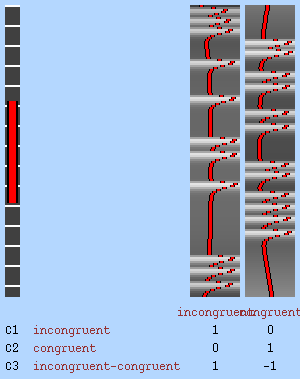

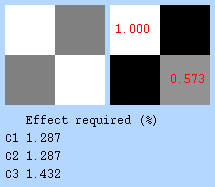

In [42]:
display(design, design_cov)

Let's now display the **thresholded activation maps**. A voxelwise threshold of Z > 3.1 was applied, followed by cluster-level correction at p < 0.05 (corrected for multiple comparisons).
- zstat1   -   C1 (incongruent)
- zstat2   -   C2 (congruent)
- zstat3   -   C3 (incongruent-congruent)

#### Incongruent

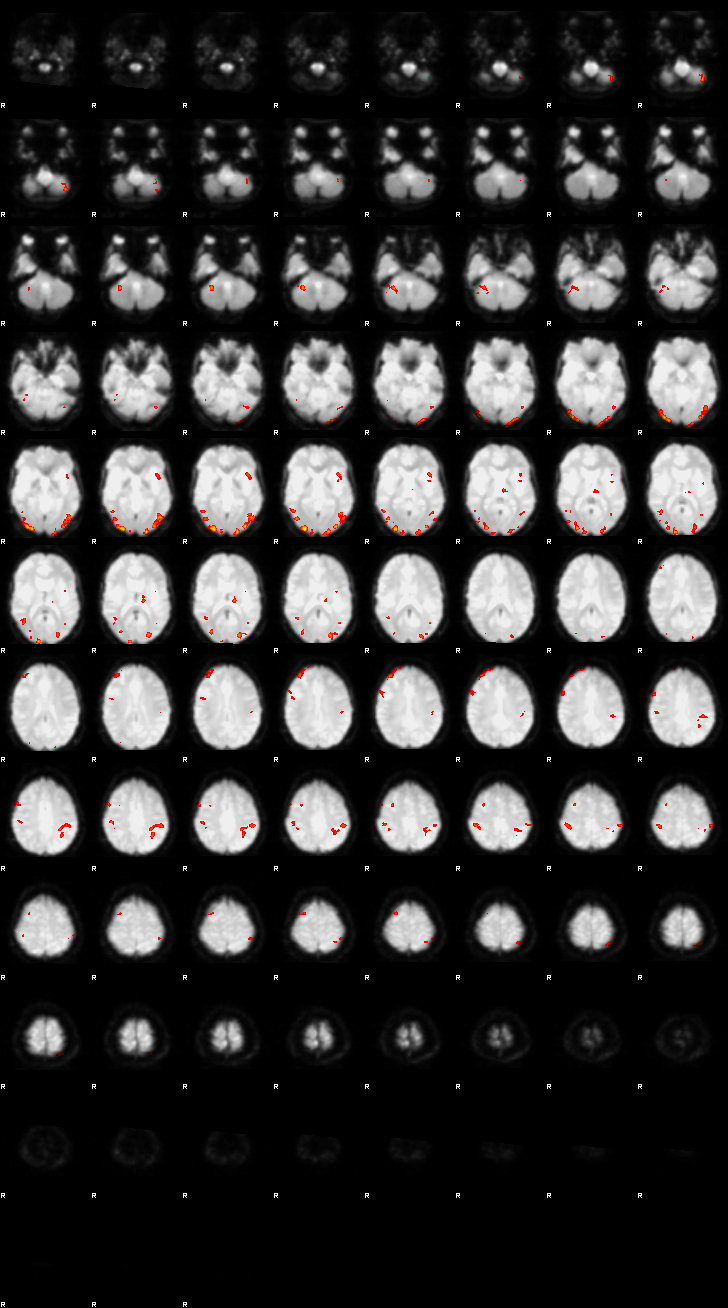

In [43]:
display(Markdown("#### Incongruent"), rendered_thresh_zstats1)

#### Congruent

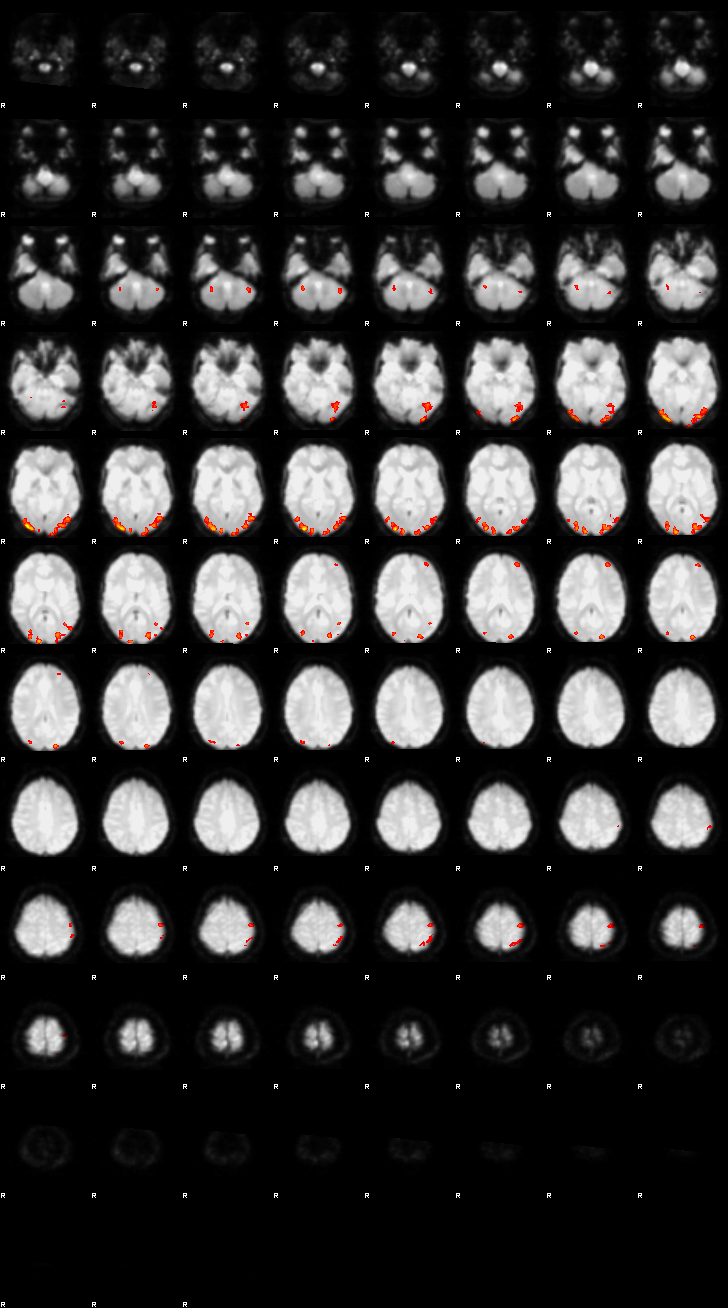

In [45]:
display(Markdown("#### Congruent"), rendered_thresh_zstats2)

#### Incongruent-Congruent

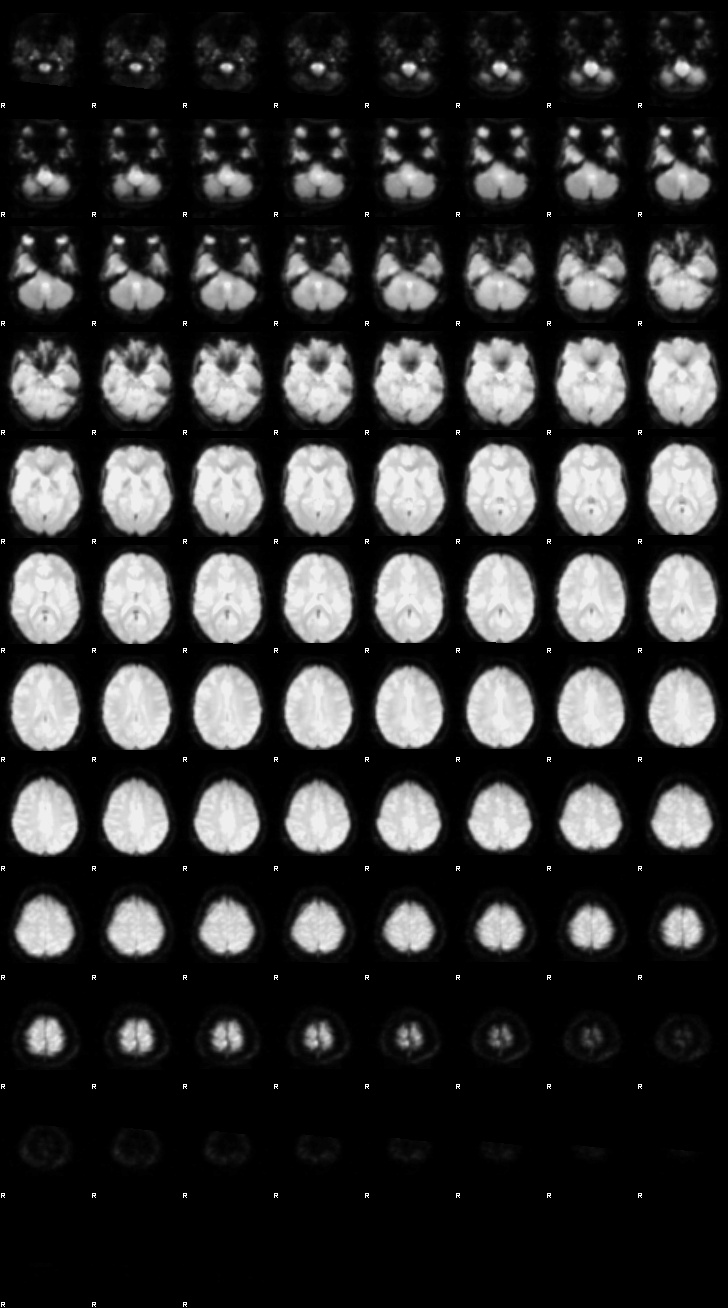

In [46]:
display(Markdown("#### Incongruent-Congruent"), rendered_thresh_zstats3)